In [1]:
import os
import time
import json
import pickle
import timeit
import random
import param
import shutil
import collections
import numpy as np
import tensorflow as tf

import stctrain
import datahelper
import stctokenizer
import nuggetdetection as ND
import dialogquality as DQ
import dialogquality_ndfeature as DQNDF
import stcevaluation as STCE

from scipy import stats
from collections import Counter
from gensim.models import Word2Vec
from gensim.models import word2vec
from gensim.models.keyedvectors import KeyedVectors

import logging
logging.basicConfig(level=logging.INFO)

Using TensorFlow backend.


In [2]:
doclen = param.doclen
embsize = param.embsize
max_sent = param.max_sent
NDclasses = param.NDclasses
DQclasses = param.DQclasses
sentembsize = param.sentembsize

REMOVE_STOPWORDS = False
TO_LOWER = True
TOKEN_TYPE = 'nltk'

datahelper = datahelper.DataHelper(embedding_path="../embedding/STCWiki/STCWiki_mincount0.model.bin")
stctokenizer = stctokenizer.STCTokenizer()

INFO:gensim.utils:loading Word2VecKeyedVectors object from ../embedding/STCWiki/STCWiki_mincount0.model.bin
INFO:gensim.utils:loading vectors from ../embedding/STCWiki/STCWiki_mincount0.model.bin.vectors.npy with mmap=None
INFO:gensim.utils:setting ignored attribute vectors_norm to None
INFO:gensim.utils:loaded ../embedding/STCWiki/STCWiki_mincount0.model.bin


## Word Embedding

In [3]:
# corpus = datahelper.prepare_word_embedding_corpus(
#     '../data/text8', 
#     TOKEN_TYPE, 
#     REMOVE_STOPWORDS, 
#     TO_LOWER,
# )

# wordemb_model = Word2Vec(corpus, size=300, min_count=0, workers=4, iter=25)
# word_vectors = wordemb_model.wv
# datahelper.test_w2v_model(word_vectors, word='problem', topn=10)

# 儲存訓練好的word2vec模型，因為已經訓練並儲存好了所以註解掉
# word_vectors.save("../embedding/STCWiki/STCWiki_mincount0.model.bin")
# datahelper.set_word_vectors(word_vectors)

## Read Corpus & Prepare data for model

In [4]:
trainX, trainND, trainDQ, train_turns, train_masks = datahelper.get_model_train_data(
    'train',
    TOKEN_TYPE, 
    REMOVE_STOPWORDS, 
    TO_LOWER,
)

devX, devND, devDQ, dev_turns, dev_masks = datahelper.get_model_train_data(
    'dev',
    TOKEN_TYPE, 
    REMOVE_STOPWORDS, 
    TO_LOWER,
)

testX, test_turns, test_masks = datahelper.get_model_test_data(token_type='nltk', remove_stopwords=False, to_lower=True)

testIDs = datahelper.testIDs
trainDQA = [item['A'] for item in trainDQ]
trainDQS = [item['S'] for item in trainDQ]
trainDQE = [item['E'] for item in trainDQ]
devDQA = [item['A'] for item in devDQ]
devDQS = [item['S'] for item in devDQ]
devDQE = [item['E'] for item in devDQ]

INFO:corpus word2vec:Training data unknown words count: 0
INFO:corpus word2vec:Training data unknown words count: 0
INFO:corpus word2vec:Testing data unknown words count: 0


In [5]:
def find_max_indices(array):
    if not np.any(array):
        return [] # all zero
    max_indices = []
    max_value = np.max(array)
    for i in range(len(array)):
        if array[i] == max_value:
            max_indices.append(i)
    return max_indices

def to_CRF_ND(max_indice):
    if len(max_indice) == 1:
        CRF_ND = np.zeros(7)
        CRF_ND[max_indice[0]] = 1
        return CRF_ND
    elif len(max_indice) == 2:
        CRF_ND1 = np.zeros(7)
        CRF_ND1[max_indice[0]] = 1
        
        CRF_ND2 = np.zeros(7)
        CRF_ND2[max_indice[1]] = 1
        return CRF_ND1, CRF_ND2
    else:
        assert False, 'Invalid max_indice len {}'.format(len(max_indice))

In [6]:
class MultipleND():
    def __init__(self, index, CRF_ND1, CRF_ND2):
        self.index = index
        self.ND1 = CRF_ND1
        self.ND2 = CRF_ND2

In [7]:
def to_CRF(dataX, dataND, turns, masks):
    crf_dataX = []
    crf_dataND = []
    crf_turns = []
    crf_masks = []
    for dialogueX, dialogueND, turn, mask in zip(dataX, dataND, turns, masks):
        crf_dialogueND = []
        mutiple_max_indices = []
        multipleND = None
        for i, utteranceND in enumerate(dialogueND):
            max_indice = find_max_indices(utteranceND)
            len_max_indice = len(max_indice)
            if len_max_indice == 0:
                crf_dialogueND.append(-1)
            elif len_max_indice == 1:
                CRF_ND = to_CRF_ND(max_indice)
                crf_dialogueND.append(np.argmax(CRF_ND))
            elif len_max_indice == 2:
                CRF_ND, CRF_ND2 = to_CRF_ND(max_indice)
                multipleND = MultipleND(i, CRF_ND, CRF_ND2)
                crf_dialogueND.append(np.argmax(CRF_ND))
                
        crf_dataX.append(dialogueX.copy())
        crf_dataND.append(crf_dialogueND.copy())
        crf_turns.append(turn-1)
        crf_masks.append(mask)
            
        if multipleND:
            crf_dialogueND[multipleND.index] = np.argmax(multipleND.ND2)
            crf_dataX.append(dialogueX.copy())
            crf_dataND.append(crf_dialogueND.copy())
            crf_turns.append(turn-1)
            crf_masks.append(mask)
            
    assert len(crf_dataX) == len(crf_dataND) == len(crf_turns) == len(crf_masks)
            
    return crf_dataX, crf_dataND, crf_turns, crf_masks

In [8]:
crf_trainX, crf_trainND, crf_train_turns, crf_train_masks = to_CRF(trainX, trainND, train_turns, train_masks)
crf_devX, crf_devND, crf_dev_turns, crf_dev_masks = to_CRF(devX, devND, dev_turns, dev_masks)

In [9]:
len(trainND), len(crf_trainND), len(devND), len(crf_devND)

(1337, 1453, 335, 368)

In [10]:
crfdataND = [crf_trainX, crf_trainND, crf_train_turns, crf_train_masks, 
             crf_devX, crf_devND, crf_dev_turns, crf_dev_masks, 
             testX, test_turns, test_masks]

In [11]:
dataND = [trainX, trainND, train_turns, train_masks, devX, devND, dev_turns, dev_masks, testX, test_turns, test_masks]
dataDQA = [trainX, trainDQA, train_turns, devX, devDQA, dev_turns, testX, test_turns]
dataDQS = [trainX, trainDQS, train_turns, devX, devDQS, dev_turns, testX, test_turns]
dataDQE = [trainX, trainDQE, train_turns, devX, devDQE, dev_turns, testX, test_turns]

In [12]:
es = 3
fixed_paramsND  = {'epoch':100, 'early_stopping':es, 'batch_size':30, 'lr':0.001, 'kp':1, 'hiddens':1024, 'Fsize':[2,2]} 
fixed_paramsDQA = {'scoretype':'DQA', 'epoch':50, 'early_stopping':es, 'batch_size':40, 'kp':1, 'lr':0.001, 'hiddens':1024, 'Fsize':[2,2]} 
fixed_paramsDQS = {'scoretype':'DQS', 'epoch':50, 'early_stopping':es, 'batch_size':40, 'kp':1, 'lr':0.001, 'hiddens':1024, 'Fsize':[2,2]} 
fixed_paramsDQE = {'scoretype':'DQE', 'epoch':50, 'early_stopping':es, 'batch_size':40, 'kp':1, 'lr':0.001, 'hiddens':1024, 'Fsize':[2,2]} 

In [13]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
def show_train_history(title, train, valid, earlystop=es):
    epoch = len(train)
    best = epoch-earlystop
    x = [i for i in range(1, epoch + 1)]
    plt.figure(figsize=(5,12))
    ax = plt.figure().gca()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.rcParams.update({'font.size': 18})
    plt.plot(x, train, marker='o', linestyle='-', color='b')
    plt.plot(x, valid, marker='o', linestyle='-', color='r')
    plt.axvline(best, color='black')
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
    plt.show()

## Test ND

In [14]:
BEST_PATH = 'ResultPickle/'
# bestND = pickle.load(open(BEST_PATH + 'bestND.p', "rb"))
bestDQAs = pickle.load(open(BEST_PATH + 'memoryDQAs.p', "rb"))
bestDQSs = pickle.load(open(BEST_PATH + 'memoryDQSs.p', "rb"))
bestDQEs = pickle.load(open(BEST_PATH + 'memoryDQEs.p', "rb"))

MemoryNone_GatingFalse_CNNRNN_1stack_rnnLayer1


INFO:Training:CNNRNN|18|False|True|2_2|1024|256|1|0.02636|0.09797


<Figure size 360x864 with 0 Axes>

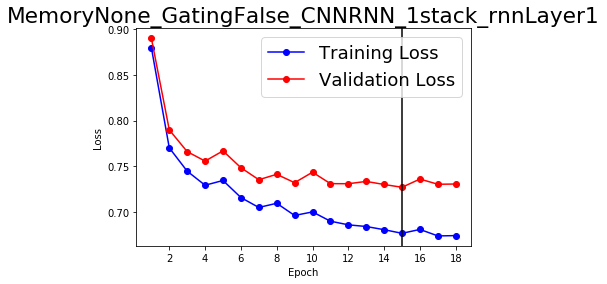

MemoryNone_GatingFalse_CNNRNN_2stack_rnnLayer1


KeyboardInterrupt: 

In [15]:
e = False
for num_layers in [1, 2, 3]:
    for mr in [None, 'Bi-GRU', 'Bi-LSTM']:
        for fn in [[256], [256, 512], [256, 512, 1024]]:
            testname = 'Memory{}_GatingFalse_CNNRNN_{}stack_rnnLayer{}'.format(mr, len(fn), num_layers)
            print(testname)
            testND, train_losses, dev_losses = stctrain.start_trainND(
                *dataND, 
                **fixed_paramsND,
                Fnum=fn, gating=False, bn=True, method=ND.CNNRNN, num_layers=num_layers, memory_rnn_type=mr,
                evaluate=e,
            )

            show_train_history(testname, train_losses, dev_losses)
#             datahelper.pred_to_submission(testND, bestDQAs[0], bestDQSs[0], bestDQEs[0], test_turns, testIDs, filename='{}.json'.format(testname))

In [ ]:
# pickle.dump(testND, open('bestND190116.p', 'wb'))

In [ ]:
stop

## Test DQ

In [ ]:
memoryNDs = pickle.load(open('ResultPickle/memoryNDs.p', 'rb'))

In [ ]:
e = True
for rm in ['Bi-GRU', 'Bi-LSTM']:
    for l in [1]:
        for fn in [[1024], [512, 1024], [256, 512, 1024]]:
            testname = 'A-GatingTrue_{}stack_Memory{}_RNNLayer{}'.format(len(fn), rm, l)
            print(testname)
            bestDQA, train_lossesA, dev_lossesA = stctrain.start_trainDQ(
                *dataDQA, 
                **fixed_paramsDQA, 
                Fnum=fn, gating=True, bn=True, method=DQ.CNNCNN, memory_rnn_type=rm, num_layers=l,
                evaluate=e,
            )

#             show_train_history(testname, train_lossesA, dev_lossesA)

            testname = 'E-GatingTrue_{}stack_Memory{}_RNNLayer{}'.format(len(fn), rm, l)
            print(testname)
            bestDQE, train_lossesE, dev_lossesE = stctrain.start_trainDQ(
                *dataDQE, 
                **fixed_paramsDQE, 
                Fnum=fn, gating=True, bn=True, method=DQ.CNNCNN, memory_rnn_type=rm, num_layers=l,
                evaluate=e,
            )

#             show_train_history(testname, train_lossesE, dev_lossesE)

            testname = 'S-GatingTrue_{}stack_Memory{}_RNNLayer{}'.format(len(fn), rm, l)
            print(testname)
            bestDQS, train_lossesS, dev_lossesS = stctrain.start_trainDQ(
                *dataDQS, 
                **fixed_paramsDQS, 
                Fnum=fn, gating=True, bn=True, method=DQ.CNNCNN, memory_rnn_type=rm, num_layers=l,
                evaluate=e
            )

#             show_train_history(testname, train_lossesS, dev_lossesS)

            testname = 'GatingTrue_{}stack_Memory{}_RNNLayer{}'.format(len(fn), rm, l)
            datahelper.pred_to_submission(memoryNDs[0], bestDQA, bestDQS, bestDQE, test_turns, testIDs, filename='{}.json'.format(testname))
            print(testname, 'is saved')

In [ ]:
# pickle.dump(bestDQAs, open('memoryDQAs.p', 'wb'))
# pickle.dump(bestDQSs, open('memoryDQSs.p', 'wb'))
# pickle.dump(bestDQEs, open('memoryDQEs.p', 'wb'))

## Test NDF

In [ ]:
memoryND = pickle.load(open('ResultPickle/bestND190116.p', 'rb'))

In [ ]:
testNDmasked = [np.multiply(nd, mask) for nd, mask in zip(memoryND, test_masks)]

In [ ]:
dataDQA_NDF = [trainX, trainDQA, train_turns, trainND, devX, devDQA, dev_turns, devND, testX, test_turns, testNDmasked]
dataDQS_NDF = [trainX, trainDQS, train_turns, trainND, devX, devDQS, dev_turns, devND, testX, test_turns, testNDmasked]
dataDQE_NDF = [trainX, trainDQE, train_turns, trainND, devX, devDQE, dev_turns, devND, testX, test_turns, testNDmasked]

In [ ]:
method = DQNDF.CNNCNN
e = True
for rm in [None]:
    for l in [1]:
        for fn in [[512, 1024]]:
            testname = 'DQNDFA-GatingTrue_{}stack_Memory{}_{}{}'.format(len(fn), rm, l, str(method).split()[1])
            print(testname)
            bestDQNDFA, train_lossesA, dev_lossesA = stctrain.start_trainDQ_NDF(
                *dataDQA_NDF, 
                **fixed_paramsDQA, 
                Fnum=fn, gating=True, bn=True, method=method, memory_rnn_type=rm, num_layers=l,
                evaluate=e,
            )

#             show_train_history(testname, train_lossesA, dev_lossesA)

            testname = 'DQNDFE-GatingTrue_{}stack_Memory{}_{}{}'.format(len(fn), rm, l, str(method).split()[1])
            print(testname)
            bestDQNDFE, train_lossesE, dev_lossesE = stctrain.start_trainDQ_NDF(
                *dataDQE_NDF, 
                **fixed_paramsDQE, 
                Fnum=fn, gating=True, bn=True, method=method, memory_rnn_type=rm, num_layers=l,
                evaluate=e,
            )

#             show_train_history(testname, train_lossesE, dev_lossesE)

            testname = 'DQNDFS-GatingTrue_{}stack_Memory{}_{}{}'.format(len(fn), rm, l, str(method).split()[1])
            print(testname)
            bestDQNDFS, train_lossesS, dev_lossesS = stctrain.start_trainDQ_NDF(
                *dataDQS_NDF, 
                **fixed_paramsDQS, 
                Fnum=fn, gating=True, bn=True, method=method, memory_rnn_type=rm, num_layers=l,
                evaluate=e
            )

#             show_train_history(testname, train_lossesS, dev_lossesS)

            testname = 'DQNDF-GatingTrue_{}stack_Memory{}_{}{}'.format(len(fn), rm, l, str(method).split()[1])
            datahelper.pred_to_submission(memoryND, bestDQNDFA, bestDQNDFS, bestDQNDFE, test_turns, testIDs, filename='{}.json'.format(testname))
            print(testname, 'is saved')

In [ ]:
# pickle.dump(bestDQANDFs, open('memoryDQANDFs.p', 'wb'))
# pickle.dump(bestDQSNDFs, open('memoryDQSNDFs.p', 'wb'))
# pickle.dump(bestDQENDFs, open('memoryDQENDFs.p', 'wb'))

In [ ]:
import numpy as np
import tensorflow as tf

# Data settings.
num_examples = 10
num_words = 20
num_features = 100
num_tags = 5

# Random features.
x = np.random.rand(num_examples, num_words, num_features).astype(np.float32)

# Random tag indices representing the gold sequence.
y = np.random.randint(num_tags, size=[num_examples, num_words]).astype(np.int32)

print(y)

# All sequences in this example have the same length, but they can be variable in a real model.
sequence_lengths = np.full(num_examples, num_words - 1, dtype=np.int32)
print(sequence_lengths)

# Train and evaluate the model.
with tf.Graph().as_default():
  with tf.Session() as session:
    # Add the data to the TensorFlow graph.
    x_t = tf.constant(x)
    y_t = tf.constant(y)
    sequence_lengths_t = tf.constant(sequence_lengths)

    # Compute unary scores from a linear layer.
    weights = tf.get_variable("weights", [num_features, num_tags])
    matricized_x_t = tf.reshape(x_t, [-1, num_features])
    matricized_unary_scores = tf.matmul(matricized_x_t, weights)
    unary_scores = tf.reshape(matricized_unary_scores,
                              [num_examples, num_words, num_tags])

    # Compute the log-likelihood of the gold sequences and keep the transition
    # params for inference at test time.
    print(unary_scores.shape)
    print(y_t.shape)
    print(sequence_lengths_t.shape)
    log_likelihood, transition_params = tf.contrib.crf.crf_log_likelihood(
        unary_scores, y_t, sequence_lengths_t)

    # Add a training op to tune the parameters.
    loss = tf.reduce_mean(-log_likelihood)
    train_op = tf.train.GradientDescentOptimizer(0.01).minimize(loss)

    # Train for a fixed number of iterations.
    session.run(tf.global_variables_initializer())
    for i in range(1000):
      tf_unary_scores, tf_transition_params, _ = session.run(
          [unary_scores, transition_params, train_op])
      if i % 100 == 0:
        correct_labels = 0
        total_labels = 0
        for tf_unary_scores_, y_, sequence_length_ in zip(tf_unary_scores, y,
                                                          sequence_lengths):
          # Remove padding from the scores and tag sequence.
          tf_unary_scores_ = tf_unary_scores_[:sequence_length_]
          y_ = y_[:sequence_length_]

          # Compute the highest scoring sequence.
          viterbi_sequence, _ = tf.contrib.crf.viterbi_decode(
              tf_unary_scores_, tf_transition_params)

          # Evaluate word-level accuracy.
          correct_labels += np.sum(np.equal(viterbi_sequence, y_))
          total_labels += sequence_length_
        accuracy = 100.0 * correct_labels / float(total_labels)
        print("Accuracy: %.2f%%" % accuracy)